Optimizing hospital procedures - predicting medical costs based on patient data
===
---

In [1]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# header
%matplotlib inline
sns.set_theme()

data_path='data/'

---
# Executive summary

---
# Input data and transformations

We use a dataset containing medical costs based on patient data from [Kaggle](https://www.kaggle.com/datasets/mirichoi0218/insurance).

In [2]:
# load the dataset
df = pd.read_csv(data_path+"insurance.csv")

We explore the dataset.

In [3]:
# explore data: quick view (data types / missing values / duplicates)

print(df.info())
print(df.sample(10))
print("\n")

# check for duplicates
print("Number of duplicate rows:", df.duplicated().sum())
print("\n")

# check for missing
print(df.isnull().sum())
print("\n")

# ? check if balanced
# print(df["target"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
      age     sex     bmi  children smoker     region      charges
72     53  female  28.100         3     no  southwest  11741.72600
945    56  female  35.800         1     no  southwest  11674.13000
444    56    male  26.695         1    yes  northwest  26109.32905
813    28    male  22.515         2     no  northeast   4428.88785
293    22  female  28.820         0     no  southeast   2156.75180
856    48  female  33.110         0    yes  southeast  40974.16490
688   

---
# Exploratory data analysis

We perform exploratory data analysis to find feature candidates.

In [4]:
# candidates for features used to train the model
# ! start with all features
features_candidates = df.columns.tolist()

df = df[features_candidates]

# print(df.info())
# print("\n")

Inspect individual features and decide on relevant transformations.

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64


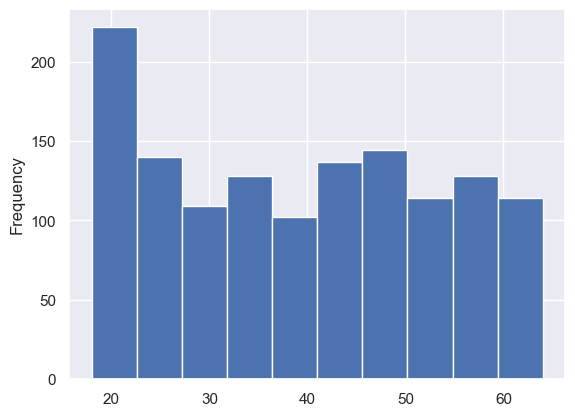

count     1338
unique       2
top       male
freq       676
Name: sex, dtype: object
sex
male      676
female    662
Name: count, dtype: int64
count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
25%        26.296250
50%        30.400000
75%        34.693750
max        53.130000
Name: bmi, dtype: float64


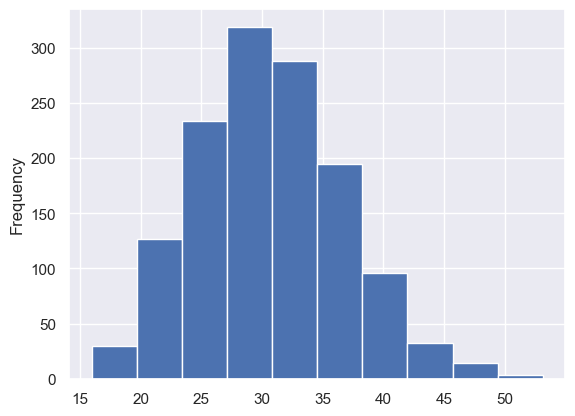

count    1338.000000
mean        1.094918
std         1.205493
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         5.000000
Name: children, dtype: float64


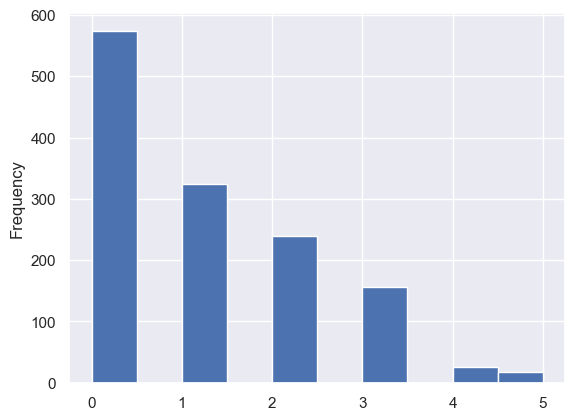

count     1338
unique       2
top         no
freq      1064
Name: smoker, dtype: object
smoker
no     1064
yes     274
Name: count, dtype: int64
count          1338
unique            4
top       southeast
freq            364
Name: region, dtype: object
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64
count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64


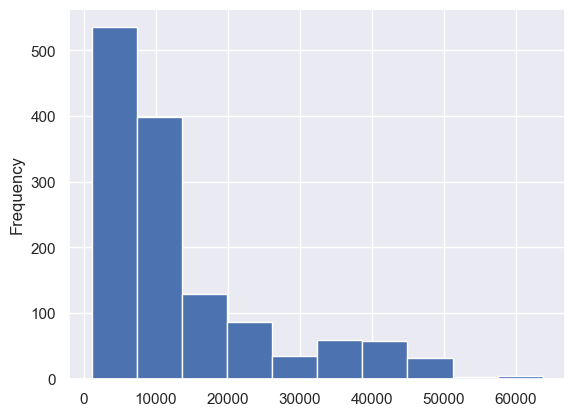

In [5]:
from pandas.api.types import is_numeric_dtype
  
# get basic characteristics
for f in features_candidates:
    print(df[f].describe())
    if is_numeric_dtype(df[f]):
        df[f].plot.hist()
        plt.show()
    else:
        print(df[f].value_counts(dropna=False))
        plt.show()

We inspect correlations between variables.

In [6]:
# check correlations
# ! numerical columns only

print(df.info())
correlations = df.select_dtypes(include=['number']).corr()
print(correlations.round(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
           age   bmi  children  charges
age       1.00  0.11      0.04     0.30
bmi       0.11  1.00      0.01     0.20
children  0.04  0.01      1.00     0.07
charges   0.30  0.20      0.07     1.00


---
# Model building
# ? feature engineering / training / validation

---
# Findings

---
# Conclusions